In [1]:
import sys
sys.path.append('../')

import tquant as tq
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import numpy as np 
import tensorflow as tf

curve_map = { #TODO inserire in libreria
    "EUR": {
        "ON": "EUR:ESTR",
        "3M": "EUR:3M",
        "6M": "EUR:6M"
    },
    "USD": {
        "ON": "USD:SOFR",
        "3M": "USD:3M",
        "6M": "USD:6M"
    }
}

In [2]:
market_data = {}

ref_date = date(2024, 7, 31)
daycounter_convention = tq.DayCounterConvention.ActualActual
daycounter = tq.DayCounter(daycounter_convention )
calendar = tq.TARGET()

mkt = pd.read_excel("market_20240731.xlsx")
mkt['start'] = mkt['start'].dt.date
mkt['end'] = mkt['end'].dt.date
estr_df = mkt[mkt['name'] == 'EUR_ESTR']
eur6m_df = mkt[mkt['name'] == 'EUR_6M']

rates = estr_df['quote'].values/100
times = [daycounter.day_count(ref_date, d) for d in estr_df['end']]

rates_6m = eur6m_df['quote'].values/100
times_6m = [daycounter.day_count(ref_date, d) for d in eur6m_df['end']]
#tq
market_data['EUR:ESTR'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=estr_df['end'],
                                    rates=rates,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)
market_data['EUR:6M'] = tq.RateCurve(reference_date=ref_date,
                                    pillars=eur6m_df['end'],
                                    rates=rates_6m,
                                    interp='LINEAR', 
                                    daycounter_convention=daycounter_convention)

# pricing t0

In [3]:
currency = tq.Currency.EUR
mod_fol_convention = tq.BusinessDayConvention.ModifiedFollowing
daycount_fix = tq.DayCounterConvention.Actual360
daycount_flt = tq.DayCounterConvention.Actual360

settlement_delay = 2 
period_fixed_leg = "1Y"
period_float_leg = "6M"
eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR, 2)

irs_eur6m_generator = tq.SwapGenerator(currency, settlement_delay, period_fixed_leg, period_float_leg, mod_fol_convention, 100e6, daycount_fix, daycount_flt, calendar, eur6m_index)
fixed_rate = 0.01
swap = irs_eur6m_generator.build(trade_date=ref_date, quote=0.01, term="20Y")

In [4]:
swap_engine = tq.SwapPricer(curve_map)
npv_swap, tape = swap_engine.price(swap, ref_date, market_data, True)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR']._rates, market_data['EUR:6M']._rates])

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 15,726,649
NPV FloatingLeg: 41,370,828
NPV Swap: 25,644,179


# simulation

In [5]:
# pre-calibrated
a = 0.142184283416318
sigma = 0.008135596903654983

hw_model = tq.HullWhiteProcess(market_data['EUR:ESTR'], a, sigma)

schedule_gen = tq.ScheduleGenerator(calendar, tq.BusinessDayConvention.Unadjusted)
end_date = calendar.advance(ref_date, 30, tq.TimeUnit.Years, tq.BusinessDayConvention.ModifiedFollowing)
dates = schedule_gen.generate(ref_date, end_date, 6, tq.TimeUnit.Months)
date_grid = tq.DateGrid(dates, tq.DayCounterConvention.ActualActual)

kernel = tq.GaussianShortRateGenerator(hw_model, date_grid)
simulated_curves = kernel.simulate_curves(1000)

In [10]:
product = swap 
index = eur6m_index
# request transaction floating leg fixings dates
schedule_dates = np.array(product.pay_dates_flt)
transaction_fixing_dates = np.array([index.fixing_date(d) for d in schedule_dates])
transaction_fixing_rates = np.zeros(shape = (transaction_fixing_dates.shape[0]))

simulated_fixing_dates = [eur6m_index.fixing_date(d) for d in date_grid.dates]
simulated_fixing_rates = tf.reduce_mean(kernel._short_rate, axis=0).numpy()

# create fixings lookup table
fixings_lookup_table = {}
for i in range(len(simulated_fixing_dates)):
    fixings_lookup_table[simulated_fixing_dates[i]] = simulated_fixing_rates[i]


# # add transaction fixing rates for a given date from fixings lookup table
for i in range(len(transaction_fixing_dates)):
    if transaction_fixing_dates[i] in fixings_lookup_table:
        transaction_fixing_rates[i] = fixings_lookup_table[transaction_fixing_dates[i]]
    else:
        # find the nearest fixing from lookup table
        transaction_fixing_rates[i] = \
        fixings_lookup_table.get(transaction_fixing_dates[i], \
        fixings_lookup_table[min(fixings_lookup_table.keys(), \
        key = lambda d: abs(d - transaction_fixing_dates[i]))])
        
for i, d in enumerate(transaction_fixing_dates):
    index.add_fixing(d, transaction_fixing_rates[i])

In [22]:
schedule_dates

array([datetime.date(2025, 2, 3), datetime.date(2025, 8, 4),
       datetime.date(2026, 2, 4), datetime.date(2026, 8, 4),
       datetime.date(2027, 2, 4), datetime.date(2027, 8, 4),
       datetime.date(2028, 2, 4), datetime.date(2028, 8, 4),
       datetime.date(2029, 2, 5), datetime.date(2029, 8, 6),
       datetime.date(2030, 2, 6), datetime.date(2030, 8, 6),
       datetime.date(2031, 2, 6), datetime.date(2031, 8, 6),
       datetime.date(2032, 2, 6), datetime.date(2032, 8, 6),
       datetime.date(2033, 2, 7), datetime.date(2033, 8, 8),
       datetime.date(2034, 2, 8), datetime.date(2034, 8, 8),
       datetime.date(2035, 2, 8), datetime.date(2035, 8, 8),
       datetime.date(2036, 2, 8), datetime.date(2036, 8, 8),
       datetime.date(2037, 2, 9), datetime.date(2037, 8, 10),
       datetime.date(2038, 2, 10), datetime.date(2038, 8, 10),
       datetime.date(2039, 2, 10), datetime.date(2039, 8, 10),
       datetime.date(2040, 2, 10), datetime.date(2040, 8, 10),
       datetime.d

In [23]:
transaction_fixing_dates

array([datetime.date(2025, 1, 30), datetime.date(2025, 7, 31),
       datetime.date(2026, 2, 2), datetime.date(2026, 7, 31),
       datetime.date(2027, 2, 2), datetime.date(2027, 8, 2),
       datetime.date(2028, 2, 2), datetime.date(2028, 8, 2),
       datetime.date(2029, 2, 1), datetime.date(2029, 8, 2),
       datetime.date(2030, 2, 4), datetime.date(2030, 8, 2),
       datetime.date(2031, 2, 4), datetime.date(2031, 8, 4),
       datetime.date(2032, 2, 4), datetime.date(2032, 8, 4),
       datetime.date(2033, 2, 3), datetime.date(2033, 8, 4),
       datetime.date(2034, 2, 6), datetime.date(2034, 8, 4),
       datetime.date(2035, 2, 6), datetime.date(2035, 8, 6),
       datetime.date(2036, 2, 6), datetime.date(2036, 8, 6),
       datetime.date(2037, 2, 5), datetime.date(2037, 8, 6),
       datetime.date(2038, 2, 8), datetime.date(2038, 8, 6),
       datetime.date(2039, 2, 8), datetime.date(2039, 8, 8),
       datetime.date(2040, 2, 8), datetime.date(2040, 8, 8),
       datetime.date(

In [18]:
tq.Settings.evaluation_date

datetime.date(2024, 8, 29)

In [20]:
t = 1

market_simulated = {}
market_simulated['EUR:ESTR'] = simulated_curves[t]
market_simulated['EUR:6M'] = simulated_curves[t]
val_date = date_grid.dates[t]
tq.Settings.evaluation_date = val_date
# eur6m_index.add_fixing(date(2024,8,1), 0.03) 
npv_swap, tape = swap_engine.price(swap, val_date, market_simulated, True)

ValueError: EUR:6M fixing time series is not complete, missing 2024-08-01

In [17]:
index.fixing_time_series

{'EUR:6M': {datetime.date(2025, 1, 30): 0.030745323029350465,
  datetime.date(2025, 7, 31): 0.0251629672991022,
  datetime.date(2026, 2, 2): 0.022363410820052276,
  datetime.date(2026, 7, 31): 0.02208677168471906,
  datetime.date(2027, 2, 2): 0.021530567778937148,
  datetime.date(2027, 8, 2): 0.020753132758047868,
  datetime.date(2028, 2, 2): 0.022410079667522072,
  datetime.date(2028, 8, 2): 0.022108267658678904,
  datetime.date(2029, 2, 1): 0.022876449313232558,
  datetime.date(2029, 8, 2): 0.022858464941266442,
  datetime.date(2030, 2, 4): 0.02354094531204979,
  datetime.date(2030, 8, 2): 0.023803865051191402,
  datetime.date(2031, 2, 4): 0.024578388343189622,
  datetime.date(2031, 8, 4): 0.024804455385386934,
  datetime.date(2032, 2, 4): 0.025575575610732905,
  datetime.date(2032, 8, 4): 0.02587558150718335,
  datetime.date(2033, 2, 3): 0.026513531968531335,
  datetime.date(2033, 8, 4): 0.027051135541688216,
  datetime.date(2034, 2, 6): 0.027568830687523024,
  datetime.date(2034, 8

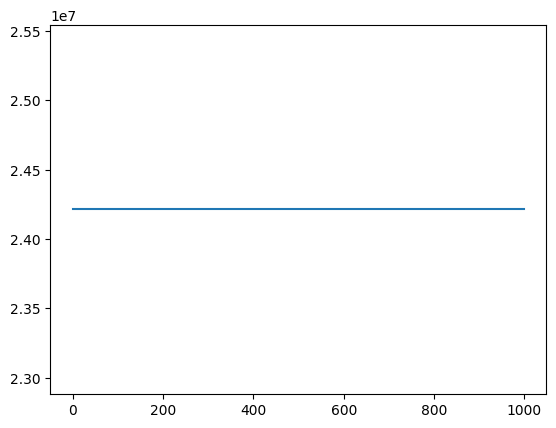

In [13]:
plt.plot(npv_swap)